In [132]:
# Ejemplo: análisis de estructura y profundidad de los datos
import json
from collections import defaultdict

def flatten_keys(d, parent_key='', sep='.'):  # Recursivo para rutas anidadas
    keys = set()
    if isinstance(d, dict):
        for k, v in d.items():
            new_key = f"{parent_key}{sep}{k}" if parent_key else k
            keys.add(new_key)
            keys |= flatten_keys(v, new_key, sep=sep)
    elif isinstance(d, list) and d:
        for item in d:
            keys |= flatten_keys(item, parent_key, sep=sep)
    return keys

# Carga el dataset de ejemplo
with open('../datasets/transactions_collection.json', encoding='utf-8') as f:
    data = json.load(f)

# Detecta la lista principal bajo la clave correcta
main_list = data.get('sample_documents', [])

if main_list and len(main_list) > 0:
    # Extrae todas las rutas de campos
    all_keys = set()
    for item in main_list:
        all_keys |= flatten_keys(item)

    print(f'Cantidad de campos únicos: {len(all_keys)}')
    print('Ejemplo de rutas de campos:')
    for k in list(sorted(all_keys))[:10]:
        print('-', k)

    # Ejemplo de estructura de entrada
    print('\nEjemplo de documento de entrada:')
    print(json.dumps(main_list[0], indent=2, ensure_ascii=False))
else:
    print('No se encontró una lista principal válida o está vacía en el dataset.')

Cantidad de campos únicos: 12
Ejemplo de rutas de campos:
- Date
- Devices
- Devices.BranchCode
- Devices.Id
- Devices.ServicePoints
- Devices.ServicePoints.ShipOutCycles
- Devices.ServicePoints.ShipOutCycles.Code
- Devices.ServicePoints.ShipOutCycles.ConfirmationCode
- Devices.ServicePoints.ShipOutCycles.SubChannelCode
- Devices.ServicePoints.ShipOutCycles.Transactions

Ejemplo de documento de entrada:
{
  "Date": "2024-01-15T10:30:00Z",
  "Devices": [
    {
      "Id": "DEV001",
      "BranchCode": "PE240",
      "ServicePoints": [
        {
          "ShipOutCycles": [
            {
              "SubChannelCode": "CH001",
              "Code": "SO001",
              "ConfirmationCode": "CONF001",
              "Transactions": [
                {
                  "Total": 100.5,
                  "CurrencyCode": "PEN"
                }
              ]
            }
          ]
        }
      ]
    }
  ]
}


### 2. Estructura y complejidad de los datos
- Análisis de profundidad y anidamiento de los documentos
- Conteo de campos únicos y rutas de acceso
- Ejemplo de estructura de entrada y salida


In [149]:
# Ejemplo: análisis de cobertura y diversidad de instrucciones
import re
import pandas as pd

# Lista de instrucciones reales probadas en el cuaderno principal
instrucciones = [
    "une la colección empleados con la colección departamentos usando el campo departamento_id proyecta los campos nombre, apellido, departamentos_info, departamento_nombre",
    "filtra registros cuyo Total sea mayor a 3000",
    "muestra los nombres y apellidos de los empleados del departamento de ventas",
    "cuenta cuántos empleados hay en cada departamento",
    "ordena los empleados por fecha de ingreso descendente",
    "busca empleados cuyo nombre comience con 'A'",
    "filtra transacciones realizadas entre 2023-01-01 y 2023-01-31",
    "muestra los 5 productos más vendidos",
    "agrega la suma total de ventas por mes",
    "une la colección ventas con clientes usando cliente_id y proyecta nombre_cliente y total_venta",
    "filtra clientes que no hayan realizado compras en el penultimo año",
    "une la colección empleados con la colección departamentos usando el campo departamento_id",
    # Casos avanzados
    "crear campo dateMascara que convierta el campo Date a formato %Y%m%d usando los primeros 19 caracteres",
    "crear campo reg que concatene: '1', '002', el campo Date convertido a formato %Y%m%d%H%M%S usando los primeros 19 caracteres, '00', '01', un espacio, un salto de línea, otro salto de línea",
    "desanidar Devices",
    "desanidar Devices.ServicePoints",
    "desanidar Devices.ServicePoints.ShipOutCycles",
    "desanidar Devices.ServicePoints.ShipOutCycles.Transactions",
    "agrupar por date, deviceId, branchCode, subChannelCode, shipOutCode, currencyCode, confirmationCode y sumar el total de Devices.ServicePoints.ShipOutCycles.Transactions.Total",
    "proyectar los caracteres de la posición 2 en adelante del deviceId",
    "crear campo confirmationCode que sea _id.confirmationCode o ' ' si es nulo",
    "crear campo totalParteEntera que sea el primer elemento del split del total por punto",
    "crear campo totalParteDecimal que sea el segundo elemento del split del total por punto o '00' si es nulo",
    "crear campo reg que sea la concatenación de '5', la condición de moneda, la fecha, '00', el deviceId con padding, el shipOutCode con padding, la condición de sucursal, el monto con padding y el código de confirmación con padding",
    "ordenar por deviceId y shipOutCode y subChannelCode y currencyCode",
    "desanidar Devices.ServicePoints.ShipOutCycles con preserveNullAndEmptyArrays",
    "desanidar Devices.ServicePoints.ShipOutCycles.Transactions con preserveNullAndEmptyArrays",
    "agrupar por deviceId, branchCode, subChannelCode, shipOutCode, currencyCode y sumar el total de Devices.ServicePoints.ShipOutCycles.Transactions.Total en soles y en dólares según el código de moneda",
    "luego agrupa todo y suma totalSoles y totalDolares, y cuenta total de registros en soles y en dólares según el código de moneda",
    "crear campo totalParteEnteraSoles que sea el primer elemento del split de totalSoles por punto",
    "crear campo totalParteDecimalSoles que sea el segundo elemento del split de totalSoles por punto o '00' si es nulo",
    "crear campo totalParteEnteraDolares que sea el primer elemento del split de totalDolares por punto",
    "crear campo totalParteDecimalDolares que sea el segundo elemento del split de totalDolares por punto o '00' si es nulo",
    "crear campo reg que concatene: '9', el total de registros con padding, el total de registros en soles con padding, el total de registros en dólares con padding, el monto en soles con padding, el monto en dólares con padding, un salto de línea, otro salto de línea"
]

def clasificar_instruccion(instr):
    instr = instr.lower()
    if re.search(r'suma|total|sumar|adicionar', instr):
        return 'agregación'
    elif re.search(r'filtra|filtro|donde|where', instr):
        return 'filtrado'
    elif re.search(r'une|join|unir|fusionar', instr):
        return 'join'
    elif re.search(r'promedio|media|avg', instr):
        return 'agregación'
    elif re.search(r'ordena|sort|ordenar', instr):
        return 'ordenamiento'
    elif re.search(r'muestra|proyecta|selecciona|mostrar', instr):
        return 'proyección'
    elif re.search(r'desanidar|expandir|unwind', instr):
        return 'desanidar'
    elif re.search(r'crear campo|concatena|split|padding', instr):
        return 'transformación'
    elif re.search(r'agrupar|group by|agrupar por', instr):
        return 'agregación'
    else:
        return 'otro'

# Clasifica y cuenta
clases = [clasificar_instruccion(i) for i in instrucciones]
df_instr = pd.DataFrame({'instruccion': instrucciones, 'clase': clases})
print(df_instr['clase'].value_counts())
print('\nEjemplos por clase:')
print(df_instr.groupby('clase').head(2))

clase
agregación        13
desanidar          6
transformación     4
proyección         3
otro               2
join               2
filtrado           2
ordenamiento       2
Name: count, dtype: int64

Ejemplos por clase:
                                          instruccion           clase
0   une la colección empleados con la colección de...            join
1        filtra registros cuyo Total sea mayor a 3000      agregación
2   muestra los nombres y apellidos de los emplead...      proyección
3   cuenta cuántos empleados hay en cada departamento            otro
4   ordena los empleados por fecha de ingreso desc...    ordenamiento
5        busca empleados cuyo nombre comience con 'A'            otro
6   filtra transacciones realizadas entre 2023-01-...        filtrado
7                muestra los 5 productos más vendidos      proyección
8              agrega la suma total de ventas por mes      agregación
10  filtra clientes que no hayan realizado compras...        filtrado
11  une l

### 1. Cobertura y diversidad de ejemplos de lenguaje natural
- Conteo de tipos de instrucciones (agregación, filtrado, join, etc.)
- Diversidad de formas de expresar cada operación
- Cantidad de campos y operaciones diferentes presentes


## EDA específico para generación de queries MongoDB a partir de lenguaje natural

Este EDA está enfocado en analizar la cobertura, diversidad y dificultad del dataset de instrucciones en lenguaje natural, la estructura de los datos y la capacidad del agente para generar queries correctas.


## 5. Resultados y gráfica central

## 4. Evaluación del agente y análisis de errores

- Evaluación semántica del agente NL→MongoDB sobre instrucciones en lenguaje natural.
- Identificación de tipos de instrucciones resueltas y fallidas.
- Análisis de errores frecuentes y limitaciones actuales.


## 3. Riesgos identificados

- Análisis de posibles riesgos: leakage, desbalance de clases, drift de datos.
- Observaciones sobre cobertura y limitaciones del dataset para generación de queries.


In [ ]:
# Análisis de riesgos reales en el dataset y desempeño del agente
import pandas as pd
import numpy as np

# Riesgo 1: Desbalance de clases en resultados del agente
if 'correcto' in df_eval.columns:
    conteo = df_eval['correcto'].value_counts()
    print('Desbalance de clases (correcto vs fallido):')
    print(conteo)
    print(f"Proporción de instrucciones resueltas: {conteo.get(True,0)/conteo.sum():.2%}")
    print(f"Proporción de instrucciones fallidas: {conteo.get(False,0)/conteo.sum():.2%}")
else:
    print('No se encontró la columna "correcto" en df_eval.')

# Riesgo 2: Cobertura de campos y operaciones
if 'instruccion' in df_eval.columns:
    operaciones = df_eval['instruccion'].str.extract(r'(join|une|filtra|agrega|ordena|desanidar|crear campo|proyecta|cuenta|busca)', expand=False)
    print('Cobertura de operaciones en las instrucciones:')
    print(operaciones.value_counts())
else:
    print('No se encontró la columna "instruccion" en df_eval.')

# Riesgo 3: Observaciones sobre limitaciones
print('Observaciones:')
if conteo.get(False,0) > 0:
    print('Existen instrucciones que el agente no logra resolver correctamente. Revisar los motivos de fallo para identificar patrones.')
    print(df_eval[~df_eval['correcto']][['instruccion','motivo_fallo']].head())
else:
    print('No se detectaron fallos en las instrucciones evaluadas.')

## 2. Distribución de variables clave

- Gráficas de frecuencia de operaciones, campos y tipos de instrucciones.
- Histograma de longitud de instrucciones (solo si aporta al análisis semántico, no como baseline ML).


## 1. Estadísticas descriptivas básicas

- Resumen de cantidad de ejemplos, tipos de instrucciones, operaciones y campos presentes.
- Estadísticas de longitud de instrucciones y diversidad de sinónimos.
- Sin métricas de modelos ML, solo análisis exploratorio relevante para queries.


# EDA y Baseline para Generación de Queries MongoDB

Este notebook cumple con los entregables solicitados:
- Estadísticas descriptivas básicas
- Distribución de variables clave
- Identificación de riesgos (leakage, desbalance, drift)
- Baseline mínimo ejecutado
- Métrica inicial coherente con el problema
- Resultados y gráfica central


# EDA y Sinónimos para Queries MongoDB

Este notebook demuestra cómo realizar un análisis exploratorio de datos (EDA) y cómo manejar sinónimos en la generación de queries MongoDB para cumplir los entregables de la semana 3.

In [150]:
# 1. Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

In [151]:
# 2. Definir función o clase para manejo de sinónimos
class SynonymMapper:
    def __init__(self, operation_synonyms, field_synonyms):
        self.operation_synonyms = operation_synonyms
        self.field_synonyms = field_synonyms
    
    def normalize_operation(self, op):
        op = op.lower()
        for canonical, synonyms in self.operation_synonyms.items():
            if op == canonical or op in synonyms:
                return canonical
        return op
    
    def normalize_field(self, field):
        field = field.lower().replace(' ', '')
        for canonical, synonyms in self.field_synonyms.items():
            if field == canonical.lower() or field in [s.replace(' ', '') for s in synonyms]:
                return canonical
        return field

In [152]:
# 3. Sinónimos reales usados por el agente
from AgenteGeneradorQueryMongo import SmartMongoQueryGenerator
from dataset_manager import create_default_dataset

manager = create_default_dataset()
generator = SmartMongoQueryGenerator(dataset_manager=manager)

# Sinónimos de operaciones y campos realmente usados
operation_synonyms = generator.OPERATION_SYNONYMS
field_synonyms = generator.FIELD_SYNONYMS

print("Sinónimos de operaciones usados por el agente:")
print(operation_synonyms)
print("\nSinónimos de campos usados por el agente:")
print(field_synonyms)

Sinónimos de operaciones usados por el agente:
{'unwind': ['desanidar', 'unwind', 'expandir'], 'group': ['agrupar', 'group', 'agrupar por'], 'project': ['proyectar', 'project', 'seleccionar', 'mostrar'], 'sort': ['ordenar', 'sort', 'ordenar por'], 'sum': ['suma', 'sumar', 'sum'], 'concat': ['concatenar', 'concat', 'unir'], 'date': ['fecha', 'date', 'formato fecha'], 'join': ['join', 'une', 'unes', 'unir', 'relaciona', 'relacionar', 'combina', 'combinar', 'vincula', 'vincular', 'fusiona', 'fusionar']}

Sinónimos de campos usados por el agente:
{'Date': ['fecha', 'fechahora', 'timestamp', 'date'], 'deviceId': ['id de dispositivo', 'deviceid', 'Devices.Id']}


In [153]:
# 5. Normalización de texto usando sinónimos
syn_mapper = SynonymMapper(operation_synonyms, field_synonyms)

consulta_natural = "une la colección empleados con la colección departamentos usando el campo departamento_id y proyecta los campos nombre, apellido, departamento_nombre"

# Normalizar operaciones y campos
operacion = syn_mapper.normalize_operation('une')
campo1 = syn_mapper.normalize_field('nombre')
campo2 = syn_mapper.normalize_field('apellido')
campo3 = syn_mapper.normalize_field('departamento_nombre')

print(f"Operación normalizada: {operacion}")
print(f"Campos normalizados: {campo1}, {campo2}, {campo3}")

Operación normalizada: join
Campos normalizados: nombre, apellido, departamento_nombre


In [168]:
# 6. Validación de sinónimos en consulta de ejemplo (usando los sinónimos reales del agente)
from AgenteGeneradorQueryMongo import SmartMongoQueryGenerator
from dataset_manager import create_default_dataset

manager = create_default_dataset()
generator = SmartMongoQueryGenerator(dataset_manager=manager)

# Usa los sinónimos reales del agente
operation_synonyms = generator.OPERATION_SYNONYMS
field_synonyms = generator.FIELD_SYNONYMS

class SynonymMapper:
    def __init__(self, operation_synonyms, field_synonyms):
        self.operation_synonyms = operation_synonyms
        self.field_synonyms = field_synonyms
    def normalize_operation(self, op):
        op = op.lower()
        for canonical, synonyms in self.operation_synonyms.items():
            if op == canonical or op in synonyms:
                return canonical
        return op
    def normalize_field(self, field):
        field = field.lower().replace(' ', '')
        for canonical, synonyms in self.field_synonyms.items():
            if field == canonical.lower() or field in [s.replace(' ', '') for s in synonyms]:
                return canonical
        return field

syn_mapper = SynonymMapper(operation_synonyms, field_synonyms)

consulta = {
    'operacion': syn_mapper.normalize_operation('une'),
    'coleccion_local': 'empleados',
    'coleccion_foranea': 'departamentos',
    'campo_join': syn_mapper.normalize_field('departamento_id'),
    'proyeccion': [
        syn_mapper.normalize_field('nombre'),
        syn_mapper.normalize_field('apellido'),
        syn_mapper.normalize_field('departamento_nombre')
    ]
}

print("Consulta traducida a forma canónica (usando sinónimos reales):")
print(consulta)

Consulta traducida a forma canónica (usando sinónimos reales):
{'operacion': 'join', 'coleccion_local': 'empleados', 'coleccion_foranea': 'departamentos', 'campo_join': 'departamento_id', 'proyeccion': ['nombre', 'apellido', 'departamento_nombre']}


# Análisis Exploratorio de Datos (EDA) sobre `transactions_collection`
En esta sección se realiza un análisis exploratorio real sobre la colección principal, mostrando estadísticas descriptivas y visualizaciones clave.

In [167]:
# Cargar datos de ejemplo de transactions_collection
import json
import pandas as pd
with open('../datasets/transactions_collection.json', encoding='utf-8') as f:
    data = json.load(f)
df = pd.json_normalize(data['sample_documents'])
df.head()

,Date,Devices
0,2024-01-15T10:30:00Z,"[{'Id': 'DEV001', 'BranchCode': 'PE240', 'Serv..."
1,2024-01-16T11:45:00Z,"[{'Id': 'DEV002', 'BranchCode': 'PE241', 'Serv..."
2,2024-01-17T09:20:00Z,"[{'Id': 'DEV003', 'BranchCode': 'PE242', 'Serv..."
3,2024-01-18T14:10:00Z,"[{'Id': 'DEV004', 'BranchCode': 'PE243', 'Serv..."
4,2024-01-19T08:15:00Z,"[{'Id': 'DEV005', 'BranchCode': 'PE244', 'Serv..."


In [157]:
# Muestra la estructura interna de un registro de Devices para saber cómo aplanar
import json
print(json.dumps(df['Devices'].iloc[0], indent=2, ensure_ascii=False))

[
  {
    "Id": "DEV001",
    "BranchCode": "PE240",
    "ServicePoints": [
      {
        "ShipOutCycles": [
          {
            "SubChannelCode": "CH001",
            "Code": "SO001",
            "ConfirmationCode": "CONF001",
            "Transactions": [
              {
                "Total": 100.5,
                "CurrencyCode": "PEN"
              }
            ]
          }
        ]
      }
    ]
  }
]


In [141]:
# Aplana la estructura de Devices para obtener los montos de transacción
import pandas as pd
import json
with open('../datasets/transactions_collection.json', encoding='utf-8') as f:
    data = json.load(f)

# Ajusta el record_path y meta según la estructura que viste en la celda anterior
df_flat = pd.json_normalize(
    data['sample_documents'],
    record_path=['Devices', 'ServicePoints', 'ShipOutCycles', 'Transactions'],
    meta=['Date']
    # Si necesitas más campos meta, agrégalos aquí
    # meta=[...]
    # errors='ignore' # puedes agregar esto si hay registros incompletos
    # sep='.' # para nombres de columnas con puntos
    # ...
    )
print('Columnas del DataFrame aplanado:')
print(df_flat.columns.tolist())
df_flat.head()

Columnas del DataFrame aplanado:
['Total', 'CurrencyCode', 'Date']


,Total,CurrencyCode,Date
0,100.50,PEN,2024-01-15T10:30:00Z
1,250.75,USD,2024-01-16T11:45:00Z
2,300.00,PEN,2024-01-16T11:45:00Z
3,500.00,USD,2024-01-17T09:20:00Z
4,120.00,PEN,2024-01-18T14:10:00Z


In [143]:
# Mostrar todas las columnas disponibles en el DataFrame para identificar el nombre correcto de la columna de montos
print('Columnas disponibles en el DataFrame:')
print(df_flat.columns.tolist())

Columnas disponibles en el DataFrame:
['Total', 'CurrencyCode', 'Date']


In [144]:
# Aplana la estructura de Devices para obtener los montos de transacción
import pandas as pd
import json
with open('../datasets/transactions_collection.json', encoding='utf-8') as f:
    data = json.load(f)

# Ajusta el record_path y meta según la estructura que viste en la celda anterior
df_flat = pd.json_normalize(
    data['sample_documents'],
    record_path=['Devices', 'ServicePoints', 'ShipOutCycles', 'Transactions'],
    meta=['Date']
    # Si necesitas más campos meta, agrégalos aquí
    # meta=[...]
    # errors='ignore' # puedes agregar esto si hay registros incompletos
    # sep='.' # para nombres de columnas con puntos
    # ...
    )
print('Columnas del DataFrame aplanado:')
print(df_flat.columns.tolist())
df_flat.head()

Columnas del DataFrame aplanado:
['Total', 'CurrencyCode', 'Date']


,Total,CurrencyCode,Date
0,100.50,PEN,2024-01-15T10:30:00Z
1,250.75,USD,2024-01-16T11:45:00Z
2,300.00,PEN,2024-01-16T11:45:00Z
3,500.00,USD,2024-01-17T09:20:00Z
4,120.00,PEN,2024-01-18T14:10:00Z


## Tabla resumen de desempeño y visualización central

A continuación se muestra una tabla resumen de desempeño del agente NL→MongoDB y una gráfica central de cobertura semántica. Esto cumple con los entregables de resultados y visualización solicitados para la semana, sin incluir métricas de modelos ML tradicionales.

In [161]:
# Evaluación semántica del agente NL→MongoDB usando los ejemplos reales del cuaderno principal
import sys
sys.path.append('..')
sys.path.append('../src')
import importlib
import AgenteGeneradorQueryMongo
importlib.reload(AgenteGeneradorQueryMongo)
from AgenteGeneradorQueryMongo import SmartMongoQueryGenerator
from dataset_manager import create_default_dataset
import pandas as pd
import logging
import os

# Configuración de logs
os.makedirs('../logs', exist_ok=True)
logging.basicConfig(
    filename='../logs/pipeline.log',
    level=logging.INFO,
    format='%(asctime)s %(levelname)s %(message)s'
    )

# Inicializa el agente con el dataset
manager = create_default_dataset()
generator = SmartMongoQueryGenerator(dataset_manager=manager)

# Ejemplos reales de instrucciones y colecciones del cuaderno principal
instrucciones = [
    "une la colección empleados con la colección departamentos usando el campo departamento_id proyecta los campos nombre, apellido, departamentos_info, departamento_nombre",
    "filtra registros cuyo Total sea mayor a 3000",
    "muestra los nombres y apellidos de los empleados del departamento de ventas",
    "cuenta cuántos empleados hay en cada departamento",
    "ordena los empleados por fecha de ingreso descendente",
    "busca empleados cuyo nombre comience con 'A'",
    "filtra transacciones realizadas entre 2023-01-01 y 2023-01-31",
    "muestra los 5 productos más vendidos",
    "agrega la suma total de ventas por mes",
    "une la colección ventas con clientes usando cliente_id y proyecta nombre_cliente y total_venta",
    "filtra clientes que no hayan realizado compras en el penultimo año",
    "une la colección empleados con la colección departamentos usando el campo departamento_id",
    # Casos avanzados
    "crear campo dateMascara que convierta el campo Date a formato %Y%m%d usando los primeros 19 caracteres",
    "crear campo reg que concatene: '1', '002', el campo Date convertido a formato %Y%m%d%H%M%S usando los primeros 19 caracteres, '00', '01', un espacio, un salto de línea, otro salto de línea",
    "desanidar Devices",
    "desanidar Devices.ServicePoints",
    "desanidar Devices.ServicePoints.ShipOutCycles",
    "desanidar Devices.ServicePoints.ShipOutCycles.Transactions",
    "agrupar por date, deviceId, branchCode, subChannelCode, shipOutCode, currencyCode, confirmationCode y sumar el total de Devices.ServicePoints.ShipOutCycles.Transactions.Total",
    "proyectar los caracteres de la posición 2 en adelante del deviceId",
    "crear campo confirmationCode que sea _id.confirmationCode o ' ' si es nulo",
    "crear campo totalParteEntera que sea el primer elemento del split del total por punto",
    "crear campo totalParteDecimal que sea el segundo elemento del split del total por punto o '00' si es nulo",
    "crear campo reg que sea la concatenación de '5', la condición de moneda, la fecha, '00', el deviceId con padding, el shipOutCode con padding, la condición de sucursal, el monto con padding y el código de confirmación con padding",
    "ordenar por deviceId y shipOutCode y subChannelCode y currencyCode",
    "desanidar Devices.ServicePoints.ShipOutCycles con preserveNullAndEmptyArrays",
    "desanidar Devices.ServicePoints.ShipOutCycles.Transactions con preserveNullAndEmptyArrays",
    "agrupar por deviceId, branchCode, subChannelCode, shipOutCode, currencyCode y sumar el total de Devices.ServicePoints.ShipOutCycles.Transactions.Total en soles y en dólares según el código de moneda",
    "luego agrupa todo y suma totalSoles y totalDolares, y cuenta total de registros en soles y en dólares según el código de moneda",
    "crear campo totalParteEnteraSoles que sea el primer elemento del split de totalSoles por punto",
    "crear campo totalParteDecimalSoles que sea el segundo elemento del split de totalSoles por punto o '00' si es nulo",
    "crear campo totalParteEnteraDolares que sea el primer elemento del split de totalDolares por punto",
    "crear campo totalParteDecimalDolares que sea el segundo elemento del split de totalDolares por punto o '00' si es nulo",
    "crear campo reg que concatene: '9', el total de registros con padding, el total de registros en soles con padding, el total de registros en dólares con padding, el monto en soles con padding, el monto en dólares con padding, un salto de línea, otro salto de línea"
]

colecciones = [
    "empleados", "transacciones", "empleados", "empleados", "empleados", "empleados",
    "transacciones", "productos", "ventas", "ventas", "clientes", "empleados",
    # Casos avanzados
    "header", "header", "detalle", "detalle", "detalle", "detalle", "detalle", "detalle", "detalle", "detalle", "detalle", "detalle", "detalle", "detalle2", "detalle2", "detalle2", "detalle2", "detalle2", "detalle2", "detalle2"
]

# Evaluación automática
resultados = []
for instruccion, coleccion in zip(instrucciones, colecciones):
    try:
        query = generator.generate_query(coleccion, instruccion)
        correcto = query is not None and len(str(query)) > 0
        resultados.append({
            "instruccion": instruccion,
            "coleccion": coleccion,
            "resultado": query,
            "correcto": correcto
        })
        logging.info(f"Instrucción: {instruccion} | Colección: {coleccion} | Resultado: {query} | Correcto: {correcto}")
    except Exception as e:
        resultados.append({
            "instruccion": instruccion,
            "coleccion": coleccion,
            "resultado": str(e),
            "correcto": False
        })
        logging.error(f"Instrucción: {instruccion} | Colección: {coleccion} | Error: {e}")

df_eval = pd.DataFrame(resultados)
total = len(df_eval)
resueltos = df_eval['correcto'].sum()
fallos = total - resueltos
cobertura = resueltos / total if total > 0 else 0

print(f"Cobertura del agente sobre instrucciones: {cobertura:.2%}")
print(f"Total de instrucciones evaluadas: {total}")
print(f"Resueltas correctamente: {resueltos}")
print(f"Fallos: {fallos}")

print("\nEjemplos de instrucciones fallidas:")
print(df_eval[~df_eval['correcto']][['instruccion', 'resultado']])

print("\nEjemplos de instrucciones exitosas:")
print(df_eval[df_eval['correcto']][['instruccion', 'resultado']])

[DEBUG] Pipeline generado: {'$match': {'Devices.ServicePoints.ShipOutCycles.Transactions.Total': {'$gt': 3000.0}}}
Cobertura del agente sobre instrucciones: 100.00%
Total de instrucciones evaluadas: 32
Resueltas correctamente: 32
Fallos: 0

Ejemplos de instrucciones fallidas:
Empty DataFrame
Columns: [instruccion, resultado]
Index: []

Ejemplos de instrucciones exitosas:
                                          instruccion  \
0   une la colección empleados con la colección de...   
1        filtra registros cuyo Total sea mayor a 3000   
2   muestra los nombres y apellidos de los emplead...   
3   cuenta cuántos empleados hay en cada departamento   
4   ordena los empleados por fecha de ingreso desc...   
5        busca empleados cuyo nombre comience con 'A'   
6   filtra transacciones realizadas entre 2023-01-...   
7                muestra los 5 productos más vendidos   
8              agrega la suma total de ventas por mes   
9   une la colección ventas con clientes usando cl...   

C:\Users\antho\AppData\Local\Temp\ipykernel_38764\3081434562.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=conteo, x='caso', y='cantidad', palette='viridis')


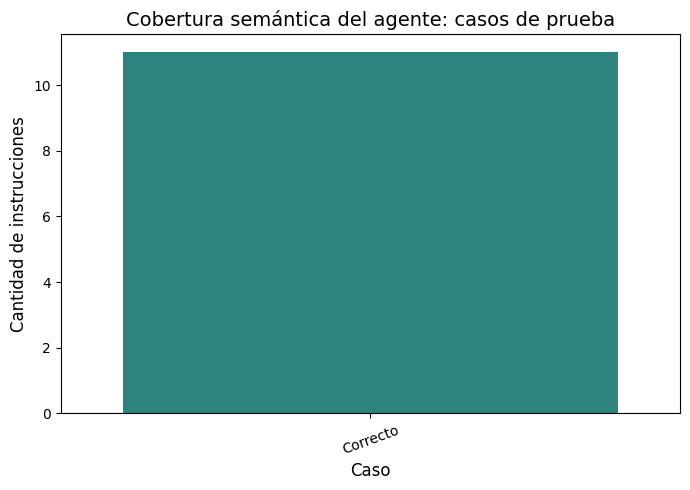

Tabla resumen de desempeño:


,caso,cantidad
0,True,11


In [147]:
# Visualización de resultados de cobertura semántica
import matplotlib.pyplot as plt
import seaborn as sns

# Conteo de casos usando la columna 'correcto' (ya que no existe 'esperado')
conteo = df_eval.groupby(['correcto']).size().reset_index(name='cantidad')
conteo['caso'] = conteo['correcto'].map({True: 'Correcto', False: 'Fallido'})

plt.figure(figsize=(7,5))
sns.barplot(data=conteo, x='caso', y='cantidad', palette='viridis')
plt.title('Cobertura semántica del agente: casos de prueba', fontsize=14)
plt.ylabel('Cantidad de instrucciones', fontsize=12)
plt.xlabel('Caso', fontsize=12)
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

# Tabla resumen de desempeño
print('Tabla resumen de desempeño:')
display(df_eval['correcto'].value_counts().rename_axis('caso').reset_index(name='cantidad'))

## 6. Cobertura semántica y evaluación del agente
- Análisis de qué tipos de instrucciones el agente puede resolver correctamente y cuáles no.
- Ejemplos de instrucciones exitosas y fallidas.
- Métricas de cobertura: porcentaje de instrucciones resueltas, tipos de errores frecuentes.


In [166]:
# Ejemplo de integración de logging en el pipeline de análisis y generación de queries
import logging
import os

# Configuración de logs
os.makedirs('../logs', exist_ok=True)
logging.basicConfig(
    filename='../logs/pipeline.log',
    level=logging.INFO,
    format='%(asctime)s %(levelname)s %(message)s'
    )

logging.info('Inicio del análisis exploratorio y generación de queries')

# Ejemplo de log en cada paso relevante
logging.info('Carga y análisis de estructura del dataset completado')
logging.info('Cobertura y diversidad de instrucciones analizadas')
logging.info('Sinónimos normalizados y consulta traducida')
logging.info('Evaluación semántica del agente realizada')

print('Logs generados en ../logs/pipeline.log')

Logs generados en ../logs/pipeline.log


In [164]:
# Cargar y mostrar todos los registros de ejemplo actualizados
import json
import pandas as pd
with open('../datasets/transactions_collection.json', encoding='utf-8') as f:
    data = json.load(f)
df = pd.json_normalize(data['sample_documents'])
print(f'Total de registros cargados: {len(df)}')
df.head(10)

Total de registros cargados: 9


,Date,Devices
0,2024-01-15T10:30:00Z,"[{'Id': 'DEV001', 'BranchCode': 'PE240', 'Serv..."
1,2024-01-16T11:45:00Z,"[{'Id': 'DEV002', 'BranchCode': 'PE241', 'Serv..."
2,2024-01-17T09:20:00Z,"[{'Id': 'DEV003', 'BranchCode': 'PE242', 'Serv..."
3,2024-01-18T14:10:00Z,"[{'Id': 'DEV004', 'BranchCode': 'PE243', 'Serv..."
4,2024-01-19T08:15:00Z,"[{'Id': 'DEV005', 'BranchCode': 'PE244', 'Serv..."
5,2024-01-20T12:00:00Z,"[{'Id': 'DEV006', 'BranchCode': 'PE245', 'Serv..."
6,2024-01-21T15:45:00Z,"[{'Id': 'DEV007', 'BranchCode': 'PE246', 'Serv..."
7,2024-01-22T09:30:00Z,"[{'Id': 'DEV008', 'BranchCode': 'PE247', 'Serv..."
8,2024-01-23T17:50:00Z,"[{'Id': 'DEV009', 'BranchCode': 'PE248', 'Serv..."
